In [1]:
#%% Import Moduels

## System Tools
import os
import sys
import numpy as np
## I/O Tools
import _pickle as pickle
## Data Process Tools
import pandas as pd
import datetime
## Graphs
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as figpdf
import matplotlib.dates as matdates
## Statistical Tools
import statsmodels.api as sm
import scipy.stats as stats
## Database API
from fredapi import Fred
## API for WRDS
import wrds

# End of Section: Import Moduels
###############################################################################


#%% Setup Working Directory
## Windows System Path
FolderList = [xx+"\\Dropbox\\Research Projects\\02_HeteFirm_AsymetricInformation\\Data\\Micro_data\\codes\\" \
              for xx in ["D:\\", "E:\\","B:\\","/mnt/b/"]]
for Folder in FolderList:
    if os.path.exists(Folder):
        os.chdir(Folder)     

## Output Folder
OutputFolder = '../results/AbReturnCyclicality/'
if not os.path.exists(OutputFolder):
    os.makedirs(OutputFolder)
# End of Section: Setup Working Directory
###############################################################################
    

# End of Section: Setup Working Directory
###############################################################################


#%% Import Self-written Functions
CodeFolder      =   "../../../../../Code/PythonLib/"

sys.path.append(CodeFolder)

import Toolkit_TimeSeries as MyTS
import Toolkit_Graphics as MyGR
# End of Section: Import Self-written Functions
###############################################################################


# Assemble the data set including firm-level characteristics

## Sample of issuance

In [2]:
DataFolder          =   "..\\temp\\"
SDC_AbRet_Wide      =   pd.read_pickle(DataFolder+"SDC_AbRet_Wide.p")
SDC_IssuanceInfo    =   pd.read_pickle(DataFolder+"SDC_IssuanceInfo.p") 

In [3]:
# Use the _1-1 window to measure the accumulated abnormal return 
VarList_AbRet = ['F_AccAbRet_-1_1', 'I_AccAbRet_-1_1']

temp = SDC_AbRet_Wide.loc[:, ['IssueID']+VarList_AbRet]
temp[VarList_AbRet] = temp[VarList_AbRet]*100

Sample = SDC_IssuanceInfo.merge(temp, how='left', left_on='IssueID', right_on='IssueID')

In [4]:
# Measure the price drop differently for firms with different shelf-issuance type 
TempInd = Sample['ShelfIssueFlag']==1

Sample['EventDate'] = Sample['FilingDate']
Sample.loc[TempInd, 'EventDate'] = Sample.loc[TempInd, 'IssueDate']

Sample['AccAbRet'] = Sample['F_AccAbRet_-1_1']
Sample.loc[TempInd, 'AccAbRet'] = Sample.loc[TempInd, 'I_AccAbRet_-1_1']

Sample['EventDate_Quarter'] = Sample['FilingDate_Quarter']
Sample.loc[TempInd, 'EventDate_Quarter'] = Sample.loc[TempInd, 'IssueDate_Quarter']

In [5]:
# Different measures of issuance 
Sample['LogProceeds'] = np.log(Sample['ProceedsAmount'])
Sample['Proceed_Asset'] = Sample['ProceedsAmount'] / Sample['TotalAsset_BeforeOffering']
Sample['Proceed_Equity'] = Sample['ProceedsAmount'] / Sample['TotalEquity']
Sample['Log_Asset'] = np.log(Sample['TotalAsset_BeforeOffering'])
Sample['Leverage'] = Sample['TotalDebt'] / Sample['TotalAsset_BeforeOffering']
Sample['ExtraShare'] = Sample['OfferedTotalShares']/Sample['TotalShares_BeforeOffering']

d:\Dropbox\Research Projects\02_HeteFirm_AsymetricInformation\Data\Env_Python\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
# Drop the observations with missing event date (14% of the sample)
Sample = Sample.dropna(subset=['EventDate'])

In [7]:
SDC_IssuanceInfo.columns

Index(['IssueID', 'IssueID_ObsNum', 'FilingDate', 'FilingDateFlag',
       'FilingDate_Year', 'FilingDate_Quarter', 'FilingDate_Month',
       'LaunchDate', 'LaunchDateFlag', 'LaunchDate_Year', 'LaunchDate_Quarter',
       'LaunchDate_Month', 'IssueDate', 'IssueDateFlag', 'IssueDate_Year',
       'IssueDate_Quarter', 'IssueDate_Month', 'GapDays_F2I', 'GapDays_L2I',
       'GapDays_F2L', 'GapBusDays_F2I', 'GapBusDays_L2I', 'GapBusDays_F2L',
       'SIC', 'FF5_Name', 'FF5_Code', 'FF10_Name', 'FF10_Code', 'Issuer',
       'Nation', 'Exchange', 'CUSIP', 'CUSIP_9digit', 'CUSIP_1_6', 'CUSIP_7_8',
       'CUSIP_8digit', 'CUSIP_DigitNum', 'TickerSymbol', 'DaysInRegistration',
       'RightsOfferFlag', 'Rule415ShelfFlag', 'ProceedsUse', 'PrincipalAmount',
       'FiledAmount', 'ProceedsAmount', 'RealPrincipalAmount',
       'RealFiledAmount', 'RealProceedsAmount', 'FiledShares',
       'OfferedTotalShares', 'OfferedPrimaryShares', 'OfferedSecondaryShares',
       'OfferAvgPrice', 'OfferedPrimar

## Merge with firm-level information

In [8]:
# Load in the SDC-CompustatQ linked data
DS_FirmInfo     =   pd.read_pickle(DataFolder+"SDC_CompustatQ_FirmInfo.p")
DS_CompustatQ   =   pd.read_pickle(DataFolder+"SDC_CompustatQ.p")

In [10]:
VarList_FirmInfo_ID = ['IssueID',  'CalendarQtr_Date']

VarList_FirmInfo_Demo = ['gvkey', 'sic', 'naics', 'year1', 'year2', 'fic', 'ipodate', 'FF10_Code', 'FF10_Name', 'FF5_Code', 'FF5_Name', \
                         'FiscalQtr',  'FiscalQtr_Year', 'FiscalQtr_Quarter', \
                         'CalendarQtr', 'CalendarQtr_Quarter', 'CalendarQtr_Year', 'CalendarQtr_Qnum']

VarList_FirmInfo_Performance = ['Diff_LogSales', 'Diff_LogSales_Quant', 'Diff_LogSales_UppQuant', 'Diff_LogSales_LowQuant', \
                                'Diff_LogAsset', 'Diff_LogAsset_Quant', 'Diff_LogAsset_UppQuant', 'Diff_LogAsset_LowQuant', \
                                'Equity_M2B', 'Equity_M2B_Quant', 'Equity_M2B_UppQuant', 'Equity_M2B_LowQuant', \
                                'Leverage', 'Cash']
VarList_FirmInfo_Performance_Lag = ['Lag_Asset', 'Lag_Asset_Quant', 'Lag_Asset_UppQuant', 'Lag_Asset_LowQuant']




In [11]:

def TempFun_ShiftQDate(Date,GapQ):
    if pd.isna(Date):
        QDate       =   Date
    else:
        Y   =   Date.year
        Q   =   int(np.ceil(Date.month/3))
        NumQ=   Y*4+Q+GapQ
        Qp  =   np.mod(NumQ,4)
        Yp  =   int((NumQ-Qp)/4)
        if Qp==0:
            Qp  =   4
            Yp  =   Yp-1
        
        QDate   =   datetime.date(Yp,Qp*3-2,1)
    
    return QDate

Sample['EventDate_Quarter_Lag'] = Sample['EventDate_Quarter'].apply(lambda x: TempFun_ShiftQDate(x,-1))

In [12]:
# Merge step 1: merge with the lag variables  
TempDS_Firm = DS_CompustatQ.loc[:, VarList_FirmInfo_ID+VarList_FirmInfo_Demo+VarList_FirmInfo_Performance_Lag]
Sample = Sample.merge(TempDS_Firm, how='left', left_on=['IssueID', 'EventDate_Quarter'], right_on=['IssueID', 'CalendarQtr_Date'], 
                      indicator=True, suffixes=('', '_drop'))
Sample = Sample.drop(columns=[col for col in Sample.columns if col.endswith('_drop')])

In [13]:
Sample['_merge'].value_counts(normalize=True)
# About 82% of the observations are matched

_merge
both          0.815805
left_only     0.184195
right_only    0.000000
Name: proportion, dtype: float64

In [14]:
Sample['Flag_Compustat'] = Sample['_merge'].map({'left_only': 0, 'right_only': 0, 'both': 1})
Sample.drop('_merge', axis=1, inplace=True)

In [36]:
VarList = ['gvkey', 'CalendarQtr', 'EventDate', 'IssueID', 'AccAbRet', 'ExtraShare', 'ProceedsAmount', 'Flag_Compustat']
temp = Sample.loc[:, VarList].dropna(subset=['gvkey', 'EventDate'])

for vv in temp.columns:
    if temp[vv].dtype=='float64':
        temp.loc[~np.isfinite(temp[vv]), vv] = np.nan 
    if temp[vv].dtype=='object':
        temp[vv] = temp[vv].astype(str) 

temp.to_stata("../results/DataForPablo/Sample_SEO.dta")

In [46]:
# Merge step 2: merge with the lagged variables
TempDS_Firm = DS_CompustatQ.loc[:, VarList_FirmInfo_ID+VarList_FirmInfo_Performance].rename(columns={vv: 'Lag_'+vv for vv in VarList_FirmInfo_Performance})
Sample = Sample.merge(TempDS_Firm, how='left', left_on=['IssueID', 'EventDate_Quarter_Lag'], right_on=['IssueID', 'CalendarQtr_Date'], suffixes=('', '_drop'))
Sample = Sample.drop(columns=[col for col in Sample.columns if col.endswith('_drop')])

# Run the regression to control the selection

## Export the data to stata

In [47]:
# temp = Sample.drop(['F_AccAbRet_-1_1', 'I_AccAbRet_-1_1'], axis=1)
# for vv in temp.columns:
#     if temp[vv].dtype=='float64':
#         temp.loc[~np.isfinite(temp[vv]), vv] = np.nan 
#     if temp[vv].dtype=='object':
#         temp[vv] = temp[vv].astype(str) 

# temp.to_stata('../temp/AbRetCyclicality_withFirmInfo.dta')

## Check the extreme values

In [48]:
Sample['AccAbRet'].describe(percentiles=[0.001, 0.01, 0.99, 0.999])

count    6207.000000
mean       -2.730429
std         9.400002
min      -112.353636
0.1%      -68.600985
1%        -34.246104
50%        -2.257500
99%        18.987822
99.9%      70.644135
max       109.360854
Name: AccAbRet, dtype: float64

In [49]:
import stata_setup
stata_setup.config("D:\\Stata18\\", "mp")
from pystata import stata 

## Push the data into Stata

In [50]:
temp = Sample.drop(['F_AccAbRet_-1_1', 'I_AccAbRet_-1_1'], axis=1)
for vv in temp.columns:
    if temp[vv].dtype=='float64':
        temp.loc[~np.isfinite(temp[vv]), vv] = np.nan 

In [51]:
stata.pdataframe_to_data(temp.reset_index(drop=True),force=True)

## Clean the data

In [52]:
stata.run('''
* Sector

generate NAICS_2 = substr(naics, 1, 2)
encode(NAICS_2), generate(NAICS_2_Code)

* Exchange 
encode(Exchange), generate(Exchange_Code)

* Firm id 
encode(gvkey), generate(gvkey_Code)

* Issuance size 
gen IssuanceSize = ProceedsAmount/MarketValue

* Date 
gen Date = date(EventDate_Quarter, "YMD")
gen Year = year(Date)
''')


. 
. * Sector
. 
. generate NAICS_2 = substr(naics, 1, 2)
(1,254 missing values generated)

. encode(NAICS_2), generate(NAICS_2_Code)

. 
. * Exchange 
. encode(Exchange), generate(Exchange_Code)



. 
. * Firm id 
. encode(gvkey), generate(gvkey_Code)

. 
. * Issuance size 
. gen IssuanceSize = ProceedsAmount/MarketValue
(316 missing values generated)

. 
. * Date 
. gen Date = date(EventDate_Quarter, "YMD")

. gen Year = year(Date)

. 


In [53]:
stata.run('gen Age=Year-year1')

(1,254 missing values generated)


In [54]:
stata.run('sum Age')


    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
         Age |      5,554    11.85794    11.30141          0         68


## Regression to filter the selection

In [55]:
def UnitRegFilter(YVar, XVarList, AbsorbVarList, SampleRestriction, WeightVar='', RegCommand='reghdfe', Level=90):
    # Compose the Stata Command
    OptionList = []
    OptionList.append('noabsorb') if len(AbsorbVarList)==0 else OptionList.append('absorb('+' '.join(AbsorbVarList)+')')
    OptionList.append('res(Res_'+str(YVar)+')')
    # Run regression
    print('Start running regression for',YVar,':')
    StataCommand = ' '.join([RegCommand,YVar]+XVarList+[SampleRestriction])+('' if len(WeightVar)==0 else ' [weight='+WeightVar+']')+', '+' '.join(OptionList)
    stata.run(StataCommand, quietly=False)
    # print(StataCommand)

    print('Done.')

    return 

In [56]:
YVar = 'AccAbRet'
XVarList = ['Lag_Asset_Quant', 'Lag_Diff_LogSales_Quant', 'Lag_Equity_M2B_Quant', 'Lag_Leverage']
AbsorbVarList = ['i.NAICS_2_Code', 'i.Exchange_Code', 'i.ShelfIssueFlag', 'i.NAICS_2_Code#c.Year', 'i.Age']
SampleRestriction = 'if Year>=1983 & AccAbRet>=-50 & AccAbRet<=50'

In [57]:
UnitRegFilter(YVar, XVarList, AbsorbVarList, SampleRestriction)

Start running regression for AccAbRet :
(dropped 1 singleton observations)
(MWFE estimator converged in 316 iterations)

HDFE Linear regression                            Number of obs   =      4,570
Absorbing 5 HDFE groups                           F(   4,   4455) =       7.01
                                                  Prob > F        =     0.0000
                                                  R-squared       =     0.0353
                                                  Adj R-squared   =     0.0106
                                                  Within R-sq.    =     0.0063
                                                  Root MSE        =     8.2051

------------------------------------------------------------------------------
    AccAbRet | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
Lag_A~_Quant |   2.644534   .8131131     3.25   0.001     1.050428    4.238639
Lag_~s_Qu

## Merge the residual into the main sample

In [58]:
AccAbRet_Filtered = stata.pdataframe_from_data(var=['IssueID', 'Res_AccAbRet'], missingval=np.nan)

In [59]:
Sample = Sample.merge(AccAbRet_Filtered, how='left', left_on='IssueID', right_on='IssueID')

# Cyclicality of the filtered abnormal returns 

## Time-series plot

In [60]:
def TempFun_WM(DS,VarList,WeightVar):
    Temp_Num        =   DS[VarList].multiply(DS[WeightVar],axis=0).sum(axis=0)
    Temp_DeNum      =   ( ~pd.isna(DS[VarList]) ).multiply(DS[WeightVar],axis=0).sum(axis=0)
    WM              =   Temp_Num.divide(Temp_DeNum,axis=0)
    WM.name         =   'WMean'
    
    return WM

DataForPlot = pd.concat([Sample.groupby('EventDate_Quarter')['Res_AccAbRet'].mean().sort_index().rename('AccAbRet_Avg'), \
                         Sample.groupby('EventDate_Quarter').apply(TempFun_WM, ['Res_AccAbRet'], 'ProceedsAmount', include_groups=False).sort_index()['Res_AccAbRet'].rename('AccAbRet_WAvg')], \
                        axis=1).sort_index()

In [61]:
# Add the aggregate price and quantity data
temp = pd.read_pickle('../../Macro_data/temp/AggDS_Dict_AggPQ.p')

DataForPlot = DataForPlot.merge(temp['Detrend'][['Growth_GDP', 'GDP']], left_index=True, right_index=True, how='left')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


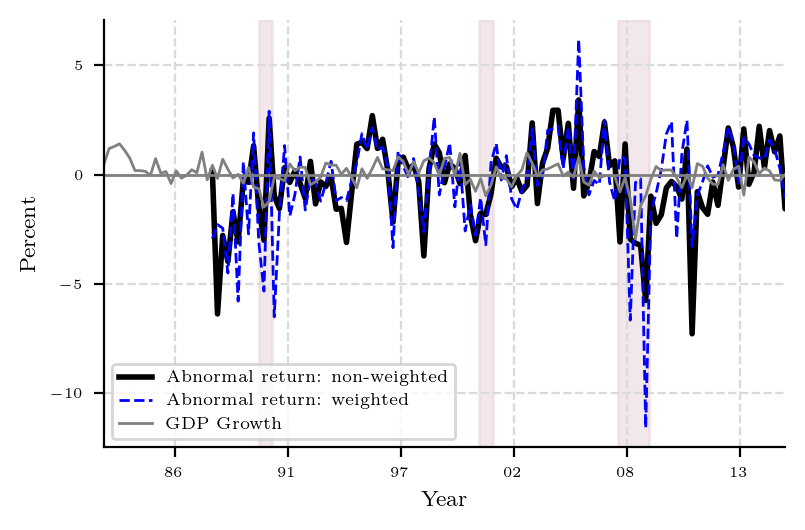

In [62]:
Fig = MyGR.Setup_Fig()
ax = Fig.add_subplot(1,1,1)
MyGR.Line(Width=2).Plot(DataForPlot.index, DataForPlot['AccAbRet_Avg'], ax=ax, Label="Abnormal return: non-weighted")
MyGR.Line(Color="Blue", Style="dashed", Width=1).Plot(DataForPlot.index, DataForPlot['AccAbRet_WAvg'], ax=ax, Label="Abnormal return: weighted")
MyGR.Line(Color="Gray", Style="solid", Width=1).Plot(DataForPlot.index, DataForPlot['Growth_GDP'], ax=ax, Label="GDP Growth")
ax.set_xlim([datetime.date(1983,1,1),datetime.date(2015,12,31)])
ax.set_ylabel('Percent', fontsize=8) 
ax.set_xlabel('Year', fontsize=8)
ax.tick_params(axis='both', labelsize=5)
MyGR.NBER_RecessionBar(ax)
MyGR.Setup_Ax(ax, XDateFlag=True, XTickNbins=10)
plt.legend(loc='lower left', fontsize=6)

plt.tight_layout()

plt.savefig(OutputFolder+'AccAbRet_BusinessCycle_Conditional.eps', format='eps', dpi=1000)

## Correlation with GDP growth

In [63]:
non_nan_index = DataForPlot.dropna().index
TempIndex = non_nan_index[(non_nan_index>=datetime.datetime(1983,1,1)) & (non_nan_index<=datetime.datetime(2015,12,31))] 

TempVarList = ['AccAbRet_Avg', 'AccAbRet_WAvg']

TempTab = pd.concat([pd.Series(stats.pearsonr(DataForPlot.loc[TempIndex, vv], DataForPlot.loc[TempIndex, 'Growth_GDP']), index=['Corr', 'p-value']) for vv in TempVarList], axis=1, keys=TempVarList)

TempTab.to_latex(OutputFolder+'Corr_w_GDPGrowth_Conditional.tex', float_format="%.3g", escape=True)

TempTab 

,AccAbRet_Avg,AccAbRet_WAvg
Corr,0.302572,0.288499
p-value,0.001248,0.002136


## Recession vs. Non-Recession

In [64]:
# Add the recession indicator
NBER_recessions = [
    (datetime.date(1980, 1, 1), datetime.date(1980, 7, 1)),
    (datetime.date(1981, 7, 1), datetime.date(1982, 11, 1)),
    (datetime.date(1990, 7, 1), datetime.date(1991, 3, 1)),
    (datetime.date(2001, 3, 1), datetime.date(2001, 11, 1)),
    (datetime.date(2007, 12, 1), datetime.date(2009, 6, 1)),
    # Add more recession periods as needed
]

def is_during_nber_recession(date):
    """
    Check if a given date falls within any NBER recession period.
'
    Parameters:
    date (datetime.date): The date to check.

    Returns:
    bool: True if the date is during an NBER recession, False otherwise.
    """
    for start, end in NBER_recessions:
        if start <= date <= end:
            return True
    return False

Sample['EventDate_RecFlag'] = Sample['EventDate'].apply(lambda x: is_during_nber_recession(x)*1 if pd.isna(x)==False else np.nan)

In [65]:
TempIndex = (Sample['EventDate']>=datetime.date(1983,1,1)) & (Sample['EventDate']<=datetime.date(2015,12,31))
TempTab = Sample.loc[TempIndex, :].groupby('EventDate_RecFlag')['Res_AccAbRet'].describe()

TempTab.to_latex(OutputFolder+'AccAbRet_RecessionVsNonRecession_Conditional.tex', float_format="%.3g", escape=True)

TempTab 

,count,mean,std,min,25%,50%,75%,max
EventDate_RecFlag,,,,,,,,
0,3954.0,0.172325,7.683350,-42.208851,-3.618233,0.350881,4.123419,45.280755
1,226.0,-1.751765,8.618597,-43.176031,-6.566721,-1.403294,2.842081,27.426199


In [66]:
# T-Test of the Abnormal Returns in recessions and non-recessions
group1 = Sample.loc[TempIndex & (Sample['EventDate_RecFlag']==1), 'Res_AccAbRet']
group2 = Sample.loc[TempIndex & (Sample['EventDate_RecFlag']==0), 'Res_AccAbRet']

# Perform the two-sample t-test
t_stat, p_value = stats.ttest_ind(group1.dropna(), group2.dropna())
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -3.6362996732099586, P-value: 0.0002799168301688663


## Mannually check the firms issuing during recession

In [67]:
RecessionSample = Sample.loc[Sample['EventDate_RecFlag']==1, :]

In [68]:
RecessionSample.to_pickle('../temp/RecessionSample.p')

In [72]:
RecessionSample.to_csv('../temp/RecessionSample.csv')

In [71]:
temp = RecessionSample[['EventDate', 'AccAbRet', 'Issuer', 'FF10_Name', 'ProceedsUse']].sort_values('EventDate')